In [1]:
import numpy as np
import pandas as pd
import networkx as nx
import operator

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

### First, we read a year's filings and take a look at the data, see what we got

In [2]:
df = pd.read_csv('../datasets/filingsEnd2020.csv')

In [3]:
# take a look
df.head()

,Unnamed: 0,filed name,cusip,value,amount,put_or_call,owner,cik,report_date
0,0,89BIO INC,282559103,1072.0,44007.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
1,1,ACTINIUM PHARMACEUTICALS INC,00507W206,702.0,90000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
2,2,ADAMAS PHARMACEUTICALS INC,00548A106,1909.0,440955.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
3,3,AFFIMED N V,N01045108,2328.0,400000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31
4,4,AKERO THERAPEUTICS INC,00973Y108,908.0,35179.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31


### Aggregating different types of securities

The CUSIP is a 9 digit alphanumeric string that is unique to each security. The first 6 characters represent the security's issuer, the next 2 represent the security type (e.g. share class), and the final character is a checksum.

As we do not want to dilute our network with unnecessary nodes, we aggregate an issuers securities under one code, the first 6 digits. The assumption here is that what matters is the total investment on a company and not its distribution over the possible security types.

In [4]:
# an issuer can have multiple different CUSIP's (first class shares, normal shares, etc)
# they are all money however so we will aggregate them in the future

df['issuer'] = df['cusip'].apply(lambda x: x[:6])
df.head()

,Unnamed: 0,filed name,cusip,value,amount,put_or_call,owner,cik,report_date,issuer
0,0,89BIO INC,282559103,1072.0,44007.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,282559
1,1,ACTINIUM PHARMACEUTICALS INC,00507W206,702.0,90000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00507W
2,2,ADAMAS PHARMACEUTICALS INC,00548A106,1909.0,440955.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00548A
3,3,AFFIMED N V,N01045108,2328.0,400000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,N01045
4,4,AKERO THERAPEUTICS INC,00973Y108,908.0,35179.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00973Y


In [5]:
# compute total value for each CIK, to normalize investments later

totalValue = df.groupby('owner')['value'].sum()

df = df.merge(totalValue, how='left', left_on='owner', right_index=True)
df.head()

,Unnamed: 0,filed name,cusip,value_x,amount,put_or_call,owner,cik,report_date,issuer,value_y
0,0,89BIO INC,282559103,1072.0,44007.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,282559,163799.0
1,1,ACTINIUM PHARMACEUTICALS INC,00507W206,702.0,90000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00507W,163799.0
2,2,ADAMAS PHARMACEUTICALS INC,00548A106,1909.0,440955.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00548A,163799.0
3,3,AFFIMED N V,N01045108,2328.0,400000.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,N01045,163799.0
4,4,AKERO THERAPEUTICS INC,00973Y108,908.0,35179.0,No,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,2020-12-31,00973Y,163799.0


In [6]:
# drop some "useless" columns

df.drop(columns=['Unnamed: 0', 'cusip', 'amount', 'put_or_call', 'report_date'], inplace=True)
df.head()

,filed name,value_x,owner,cik,issuer,value_y
0,89BIO INC,1072.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,282559,163799.0
1,ACTINIUM PHARMACEUTICALS INC,702.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,00507W,163799.0
2,ADAMAS PHARMACEUTICALS INC,1909.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,00548A,163799.0
3,AFFIMED N V,2328.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,N01045,163799.0
4,AKERO THERAPEUTICS INC,908.0,"SILVERARC CAPITAL MANAGEMENT, LLC",1816307,00973Y,163799.0


### Normalized values

We are looking to investigate the behavior of the US financial market. However, some investors are way larger than others. For example, Vanguard has more than 3 trillion USD under management while the threshold for filing a 13F report is 100 million USD. For that reason, a significant investment for an investor, let's say half his total value, can be negligible for larger firms when compared on an absolute scale.

In order to avoid our graphs being dominated by large investors and to gain insights on the behavior of all "players" in the market, we normalize each position's value by dividing with the investors total value. That way, we can assume that an investment is important and warrants an edge if it surpasses a certain threshold, like 2% of total value.

In [7]:
# compute normalized value

df['norm_value'] = df['value_x'] / df['value_y']

In [8]:
# some have reported investments of value==0, drop them

mask = df['value_x'] == 0
df = df.loc[~mask]

In [9]:
# we're gonna need the issuer names for labeling

issuers = df.drop_duplicates(subset='issuer')
issuers['label'] = issuers['filed name'].apply(lambda x: ' '.join(x[:].split(' ')[:3]))
issuers = issuers[['label', 'issuer']]
#issuers

<ipython-input-9-d5e49a45e54f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  issuers['label'] = issuers['filed name'].apply(lambda x: ' '.join(x[:].split(' ')[:3]))


In [10]:
# perform final aggregation and inspect

df = df.groupby(['cik','issuer']).agg({'norm_value': 'sum'})
df = df.reset_index()
df

,cik,issuer,norm_value
0,5272,000360,0.000068
1,5272,000361,0.000030
2,5272,00081T,0.000017
3,5272,000868,0.000005
4,5272,000899,0.000003
...,...,...,...
160448,1849834,25809K,0.934931
160449,1849834,31188V,0.014215
160450,1849834,31816Q,0.025669
160451,1849834,68376D,0.012929


### Calculating the feature map

In order to follow method 1, we need to calculate the correlation between investment stretegies of different investors. To do that, we transform the DataFrame into wide format, with each investor represented by a feature vector and each security issuer as a feature, with the value of the feature being equal to the normalized value of the position.

In [11]:
# we need to turn the DF into wide form, use it like feature vectors

wideDf = df.pivot(index='cik', columns='issuer', values='norm_value').fillna(value=0)
wideDf

issuer,00000I,00000K,00000L,00000N,000360,000361,000375,000380,00080Q,00081T,...,m7516k,n44821,n53745,n6596x,n71542,n72482,y09827,y2106r,y2573f,y8564m
cik,,,,,,,,,,,,,,,,,,,,,
5272,0.0,0.0,0.0,0.0,0.000068,0.00003,0.000000,0.000000e+00,0.0,0.000017,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
19617,0.0,0.0,0.0,0.0,0.000008,0.00004,0.000002,1.462913e-07,0.0,0.000033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
20286,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48966,0.0,0.0,0.0,0.0,0.000000,0.00000,0.006491,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
52234,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1846462,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1846639,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1846789,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000e+00,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Calculation and visualization of the correlation matrix

After calculating the correlation between investors, the results are not useful when inspecting because they are noisy and not grouped together. 

We fix this by performing hierarchical clustering on the matrix and observing the resulting visualization.

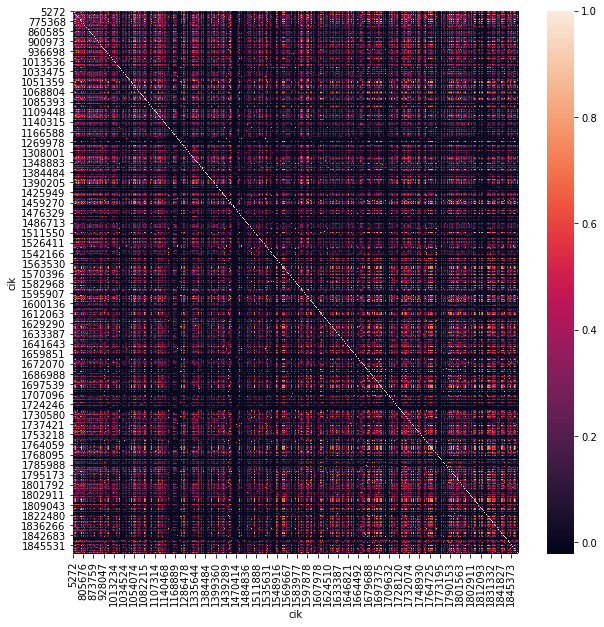

In [12]:
# compute correlation between investors

correlation = wideDf.transpose().corr()

plt.figure(figsize=(10,10))
sns.heatmap(correlation);

/home/jradhima/miniconda3/envs/mda/lib/python3.8/site-packages/seaborn/matrix.py:649: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


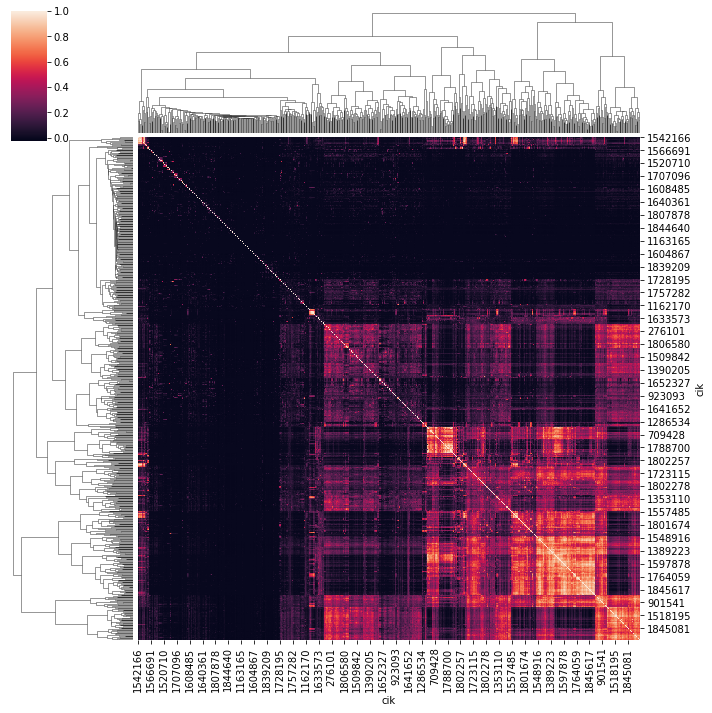

In [13]:
# pick a method out of 'single', 'complete', 'centroid', 'ward'

method = 'complete'

# cluster the correlation matrix to show connectivity

clmap = sns.clustermap(correlation, method=method)

### Proper network analysis

We create the bipartite network with investors and companies (security issuers). We include an edge from an investor to a company only if the normalized value of the position is above a cetrain threshold.

We can control the network layout via the "gravity" parameter. Low values lead to spread-out layouts, high values lead to clustered layouts.

For the layout positions, we use the spring layout.

In [14]:
# pick a threshold below which no edge is added on the graph
# for example, threshold = 0.025

threshold = 0.05

# now pick an 'gravity' factor
# factors above 1 lead to a more clustered graph
# factors below 1 lead to a more spread-out graph
# values between 0.5-1 make best graphs
# lower threshold values need lower gravity factors

gravity = 0.4

investors = []
companies = []

G=nx.Graph()
for i in df.index:
    edge = df.iloc[i,]
    if edge['norm_value'] > threshold:
        G.add_edge(edge['cik'], edge['issuer'], weight=edge['norm_value'] ** (1/gravity))
        investors.append(edge['cik'])
        companies.append(edge['issuer'])

In [15]:
# calculate centrality
degCent = nx.degree_centrality(G)

# get positions
pos = nx.spring_layout(G)  # positions for all nodes

In [16]:
print(f"Nodes in graph: {len(G.nodes())}\nEdges in graph: {len(G.edges())}")

Nodes in graph: 1457
Edges in graph: 2393


In [17]:
# calculate node size based on centrality for each group

investorSize = [degCent[investor]**1.5 * 10000 for investor in investors]
issuerSize = [degCent[issuer]**1.5 * 10000 for issuer in companies]

# calculate edge size
edgeSize = [d['weight'] ** (gravity) for (u, v, d) in G.edges(data=True)]

In [18]:
#pick how many labels you want displayed

num = 20

# get num most central issuers
sorted_x = sorted(degCent.items(), key=operator.itemgetter(1), reverse=True)
central = [item[0] for item in sorted_x[:num] if type(item[0]) == str]

# turn list into dictionary
labels = {}
for code in central:
    try:
        labels[code] = issuers[issuers['issuer'] == code]['label'].item()
    except:
        labels[code] = code

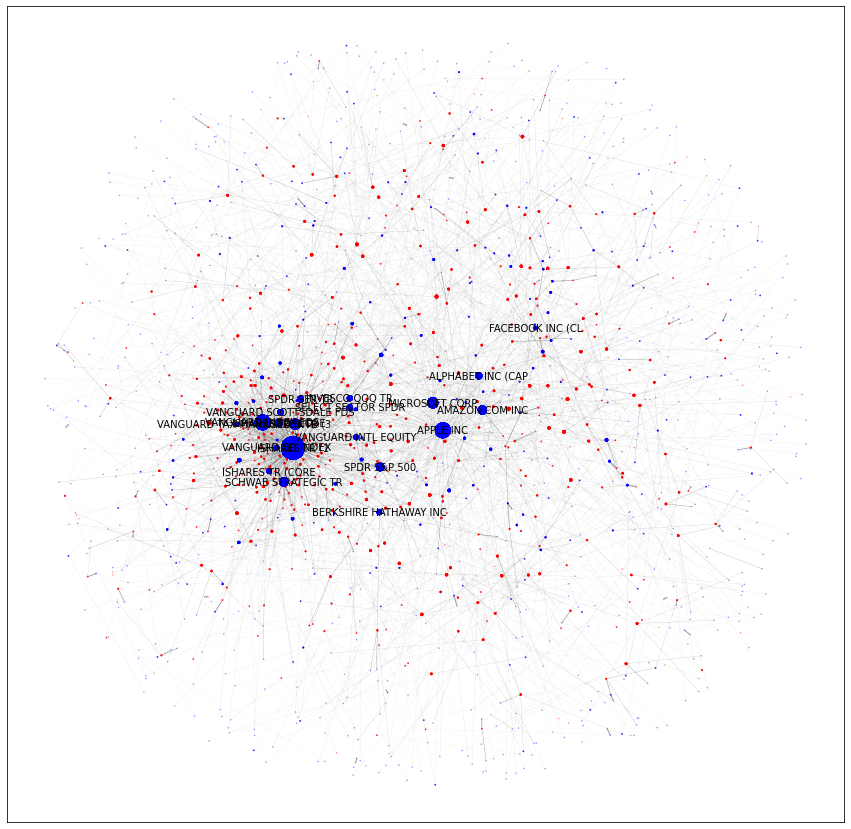

In [19]:
# let's draw
plt.figure(figsize=(15,15))

# draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=investors, node_size=investorSize, alpha=0.5, node_color='r')

# draw nodes
nx.draw_networkx_nodes(G, pos, nodelist=companies, node_size=issuerSize, alpha=0.5, node_color='b')

# edges
nx.draw_networkx_edges(
    G, pos, width=edgeSize, alpha=0.4, edge_color="k")

# labels
nx.draw_networkx_labels(G, pos, labels=labels, font_size=10, font_family="sans-serif", font_color='k');